In [1]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
import pickle

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To format floats
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

/home/nacho/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#Load all the csv files into Pandas dataframes

X_train = np.loadtxt(open("../data/interim/X_train.csv", "rb"), delimiter=",")
X_test = np.loadtxt(open("../data/interim/X_test.csv", "rb"), delimiter=",")
df_labels = pd.read_csv('../data/raw/train_labels.csv')
SubmissionFormat = pd.read_csv('../data/raw/SubmissionFormat.csv')

y_train = df_labels.status_group.values

#### Let's create a dumb model that always predict the most common label

In [7]:
class AlwaysFunctionalClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return ['functional'] * len(X)

#### Compare models without optimization

In [8]:
models = {
    "Dumb Model": AlwaysFunctionalClassifier(),
    "SGD Classifier": SGDClassifier(),
    "Random Forests": RandomForestClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Softmax Regression": LogisticRegression(multi_class="multinomial",solver="lbfgs"),
    "SVM": SVC(decision_function_shape="ovr"),
    "Decission Trees": DecisionTreeClassifier(),
    "AdaBoost":AdaBoostClassifier(algorithm="SAMME.R"),
    "Gradient Boost":GradientBoostingClassifier()
}

results = []
names = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v, X=X_train, y=y_train, cv=10, n_jobs=1, scoring='accuracy')
    
    results.append(cv_scores)
    names.append(k)

    print(k)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('----------------')

Dumb Model
CV accuracy: 0.543 +/- 0.007
----------------
SGD Classifier
CV accuracy: 0.730 +/- 0.004
----------------
Random Forests
CV accuracy: 0.771 +/- 0.005
----------------
k-Nearest Neighbors
CV accuracy: 0.780 +/- 0.005
----------------
Softmax Regression
CV accuracy: 0.740 +/- 0.007
----------------
SVM
CV accuracy: 0.745 +/- 0.005
----------------
Decission Trees
CV accuracy: 0.732 +/- 0.007
----------------
AdaBoost
CV accuracy: 0.708 +/- 0.003
----------------
Gradient Boost
CV accuracy: 0.760 +/- 0.003
----------------


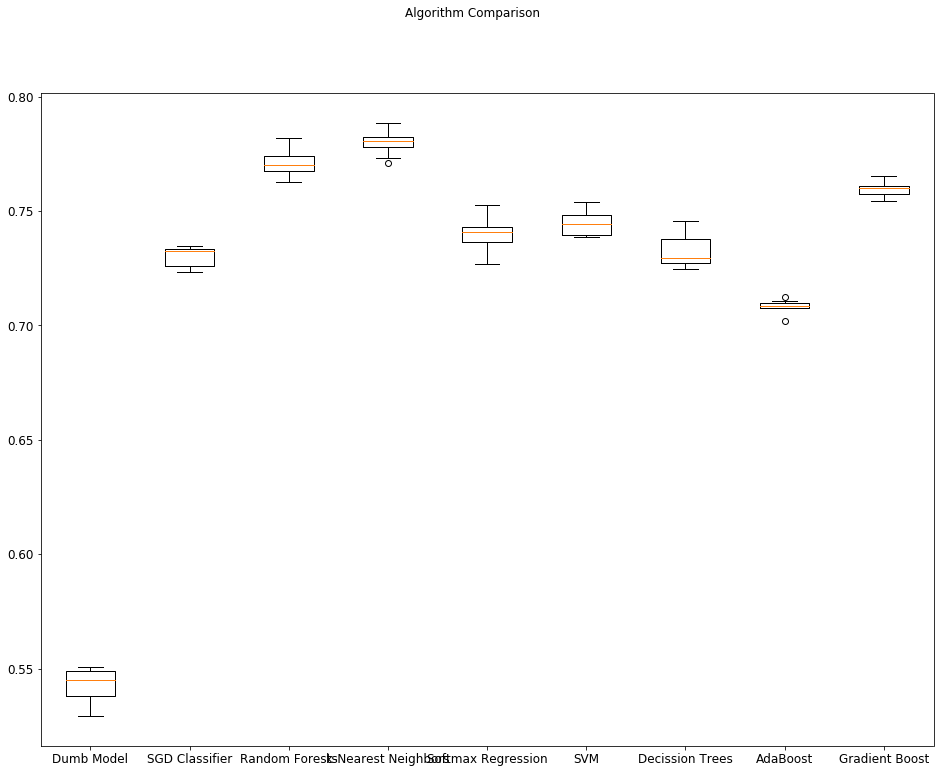

In [9]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Let's try to optimize some of this models

#### Random Forests
Initial performance

In [5]:
forest_clf = RandomForestClassifier()
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.76333333,  0.76787879,  0.76707071])

Random Forests Confusion Matrix

In [25]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

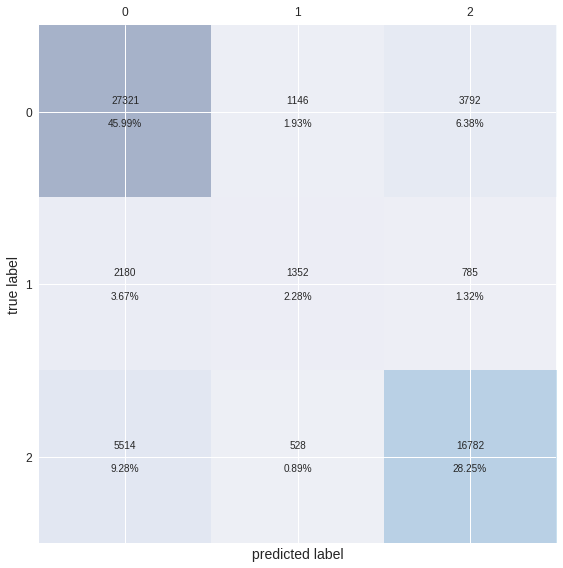

In [26]:
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

In [6]:
param_grid = [{'max_depth': [ 30, 60], 
               'n_estimators': [ 80, 300],
               'max_features': [5, 10],
               'min_samples_leaf': [1, 10],
               'n_jobs': [-1]}]

grid_search_rf = GridSearchCV(forest_clf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=80, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=80, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=80, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=300, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=300, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=300, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=10, n_estimators=80, n_jobs=-1 
[CV] max_depth=30, max_features=5, min_samples_leaf=10, n_estimators=80, n_jobs=-1 
[CV]  max_depth=30, max_features=5, min_samples_leaf=1, n_estimators=80, n_jobs=-1, total=  28.2s
[CV] max_depth=30, max_features=5, min_samples_leaf=10, n_estimators=80, n_jobs=-1 
[CV]  max_depth=30, max_features=5, min_samples_leaf=10, n_estimators=80, n_jobs=-1, tot

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.6min


[CV]  max_depth=30, max_features=10, min_samples_leaf=10, n_estimators=300, n_jobs=-1, total= 3.1min
[CV] max_depth=60, max_features=5, min_samples_leaf=10, n_estimators=300, n_jobs=-1 
[CV]  max_depth=60, max_features=5, min_samples_leaf=1, n_estimators=300, n_jobs=-1, total= 1.9min
[CV] max_depth=60, max_features=5, min_samples_leaf=10, n_estimators=300, n_jobs=-1 
[CV]  max_depth=30, max_features=10, min_samples_leaf=10, n_estimators=300, n_jobs=-1, total= 3.0min
[CV] max_depth=60, max_features=5, min_samples_leaf=10, n_estimators=300, n_jobs=-1 
[CV]  max_depth=60, max_features=5, min_samples_leaf=10, n_estimators=80, n_jobs=-1, total=  26.9s
[CV] max_depth=60, max_features=10, min_samples_leaf=1, n_estimators=80, n_jobs=-1 
[CV]  max_depth=60, max_features=5, min_samples_leaf=10, n_estimators=80, n_jobs=-1, total=  25.5s
[CV] max_depth=60, max_features=10, min_samples_leaf=1, n_estimators=80, n_jobs=-1 
[CV]  max_depth=60, max_features=5, min_samples_leaf=10, n_estimators=80, n_jo

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 10.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [30, 60], 'n_estimators': [80, 300], 'max_features': [5, 10], 'min_samples_leaf': [1, 10], 'n_jobs': [-1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [7]:
cvres = grid_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.780791245791 {'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 80, 'n_jobs': -1}
0.783703703704 {'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 300, 'n_jobs': -1}
0.791178451178 {'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 80, 'n_jobs': -1}
0.791262626263 {'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 300, 'n_jobs': -1}
0.78196969697 {'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 80, 'n_jobs': -1}
0.783838383838 {'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 300, 'n_jobs': -1}
0.790909090909 {'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 10, 'n_estimators': 80, 'n_jobs': -1}
0.792558922559 {'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 10, 'n_estimators': 300, 'n_jobs': -1}
0.778754208754 {'max_depth': 60, 'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 80, 'n_jobs': -1}
0.781144

In [8]:
grid_search_rf.best_params_

{'max_depth': 30,
 'max_features': 10,
 'min_samples_leaf': 10,
 'n_estimators': 300,
 'n_jobs': -1}

In [9]:
pickle.dump(grid_search_rf, open('../models/grid_search_rf.sav', 'wb'))

#### SGD Classifier
Initial performance

In [10]:
sgd_clf = SGDClassifier()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.72383838,  0.71590909,  0.72520202])

SGD Confusion Matrix

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

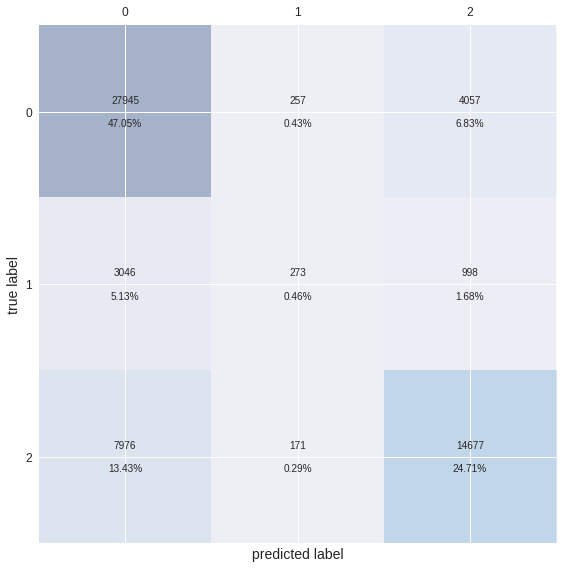

In [33]:
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

In [11]:
param_grid = [{'penalty': ['none', 'l2','l1','elasticnet'], 
               'alpha': [ 0.00001,  0.0001,  0.001,  0.01],
               'loss': ['log'],
               'n_jobs': [-1]}]

grid_search_sgd = GridSearchCV(sgd_clf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_sgd.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=none ..................
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=none ..................
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=none ..................
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=l2 ....................
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=l2 ....................
[CV] ... alpha=1e-05, loss=log, n_jobs=-1, penalty=none, total=   0.3s
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=l2 ....................
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=l1 ....................
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=l1 ....................
[CV] ... alpha=1e-05, loss=log, n_jobs=-1, penalty=none, total=   0.5s
[CV] ... alpha=1e-05, loss=log, n_jobs=-1, penalty=none, total=   0.5s
[CV] alpha=1e-05, loss=log, n_jobs=-1, penalty=l1 ....................
[CV] ..... alpha=1e-05, loss=log, n_jobs=-1, penalty=l2, total=   0.5s
[CV] alpha=1e-05

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s


[CV] alpha=0.001, loss=log, n_jobs=-1, penalty=elasticnet ............
[CV] ..... alpha=0.001, loss=log, n_jobs=-1, penalty=l2, total=   0.7s
[CV] ... alpha=0.001, loss=log, n_jobs=-1, penalty=none, total=   0.8s
[CV] alpha=0.001, loss=log, n_jobs=-1, penalty=elasticnet ............
[CV] alpha=0.001, loss=log, n_jobs=-1, penalty=elasticnet ............
[CV] ..... alpha=0.001, loss=log, n_jobs=-1, penalty=l2, total=   0.6s
[CV] ..... alpha=0.001, loss=log, n_jobs=-1, penalty=l2, total=   0.7s
[CV] alpha=0.01, loss=log, n_jobs=-1, penalty=none ...................
[CV] alpha=0.01, loss=log, n_jobs=-1, penalty=none ...................
[CV] ..... alpha=0.001, loss=log, n_jobs=-1, penalty=l1, total=   1.1s
[CV] alpha=0.01, loss=log, n_jobs=-1, penalty=none ...................
[CV] ..... alpha=0.001, loss=log, n_jobs=-1, penalty=l1, total=   1.1s
[CV] alpha=0.01, loss=log, n_jobs=-1, penalty=l2 .....................
[CV]  alpha=0.001, loss=log, n_jobs=-1, penalty=elasticnet, total=   1.1s
[CV

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    7.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'penalty': ['none', 'l2', 'l1', 'elasticnet'], 'alpha': [1e-05, 0.0001, 0.001, 0.01], 'loss': ['log'], 'n_jobs': [-1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [12]:
cvres = grid_search_sgd.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.657037037037 {'alpha': 1e-05, 'loss': 'log', 'n_jobs': -1, 'penalty': 'none'}
0.699057239057 {'alpha': 1e-05, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
0.703097643098 {'alpha': 1e-05, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l1'}
0.701952861953 {'alpha': 1e-05, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.731515151515 {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'none'}
0.730067340067 {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
0.734208754209 {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l1'}
0.734006734007 {'alpha': 0.0001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.73771043771 {'alpha': 0.001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'none'}
0.73595959596 {'alpha': 0.001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
0.733434343434 {'alpha': 0.001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l1'}
0.736902356902 {'alpha': 0.001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
0.736464646465 {'alpha': 0.01, '

In [13]:
grid_search_sgd.best_params_

{'alpha': 0.001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'none'}

In [14]:
pickle.dump(grid_search_sgd, open('../models/grid_search_sgd.sav', 'wb'))

#### K Nearest Neighbors
Initial performance

In [15]:
knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.77494949,  0.77121212,  0.7739899 ])

KNN Confusion Matrix

In [40]:
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

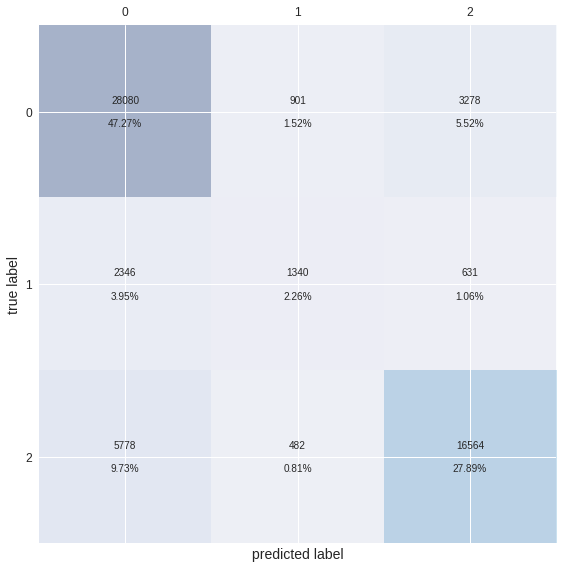

In [41]:
conf_mx = confusion_matrix(y_train, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_mx, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mx.shape[0]):
    for j in range(conf_mx.shape[1]):
        perc = str(round((conf_mx[i, j]/conf_mx.sum())*100,2)) + "%"
        ax.text(x=j, y=i, s=str(conf_mx[i, j])+"\n\n"+perc, va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

In [16]:
param_grid = [{'n_neighbors': [ 3, 5, 10], 
               'weights': [ 'uniform',  'distance'],
               'n_jobs': [-1]}]

grid_search_knn = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_jobs=-1, n_neighbors=3, weights=uniform .......................
[CV] n_jobs=-1, n_neighbors=3, weights=uniform .......................
[CV] n_jobs=-1, n_neighbors=3, weights=uniform .......................
[CV] n_jobs=-1, n_neighbors=3, weights=distance ......................
[CV] n_jobs=-1, n_neighbors=3, weights=distance ......................
[CV] n_jobs=-1, n_neighbors=3, weights=distance ......................
[CV] n_jobs=-1, n_neighbors=5, weights=uniform .......................
[CV] n_jobs=-1, n_neighbors=5, weights=uniform .......................
[CV] ........ n_jobs=-1, n_neighbors=3, weights=uniform, total=  51.9s
[CV] n_jobs=-1, n_neighbors=5, weights=uniform .......................
[CV] ........ n_jobs=-1, n_neighbors=3, weights=uniform, total=  51.8s
[CV] n_jobs=-1, n_neighbors=5, weights=distance ......................
[CV] ....... n_jobs=-1, n_neighbors=3, weights=distance, total=  54.3s
[CV] n_jobs=-1, n

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  6.6min remaining:  2.5min


[CV] ....... n_jobs=-1, n_neighbors=10, weights=uniform, total= 1.7min
[CV] ....... n_jobs=-1, n_neighbors=10, weights=uniform, total= 1.8min
[CV] ...... n_jobs=-1, n_neighbors=10, weights=distance, total= 1.9min
[CV] ...... n_jobs=-1, n_neighbors=10, weights=distance, total= 1.3min
[CV] ...... n_jobs=-1, n_neighbors=10, weights=distance, total= 1.2min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance'], 'n_jobs': [-1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [17]:
cvres = grid_search_knn.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.771430976431 {'n_jobs': -1, 'n_neighbors': 3, 'weights': 'uniform'}
0.766346801347 {'n_jobs': -1, 'n_neighbors': 3, 'weights': 'distance'}
0.773383838384 {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}
0.772575757576 {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
0.768821548822 {'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}
0.777171717172 {'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}


In [18]:
grid_search_knn.best_params_

{'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}

In [19]:
pickle.dump(grid_search_knn, open('../models/grid_search_knn.sav', 'wb'))

### Classification with XGBoost

In [20]:
param_grid = [{'max_depth': [ 3, 10], 
               'n_estimators': [ 80, 300],
               'learning_rate': [0.01, 0.1, 0.3]}]

gbm = xgb.XGBClassifier()
grid_search_xgb = GridSearchCV(gbm, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=0.01, max_depth=3, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=3, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=3, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............
[CV] . learning_rate=0.01, max_depth=3, n_estimators=80, total= 2.2min
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............
[CV] . learning_rate=0.01, max_depth=3, n_estimators=80, total= 2.3min
[CV] learning_rate=0.01, max_depth=10, n_estimators=300 ..............
[CV] . learning_rate=0.01, max_depth=3, n_estimators=80, total= 2.3min
[CV] learning_ra

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 61.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [3, 10], 'n_estimators': [80, 300], 'learning_rate': [0.01, 0.1, 0.3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [21]:
cvres = grid_search_xgb.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.675858585859 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 80}
0.718872053872 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
0.773148148148 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 80}
0.78771043771 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
0.745387205387 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
0.772861952862 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
0.792373737374 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}
0.788484848485 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
0.767878787879 {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 80}
0.786262626263 {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
0.786936026936 {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 80}
0.782121212121 {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300}


In [22]:
grid_search_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}

In [23]:
pickle.dump(grid_search_xgb, open('../models/grid_search_xgb.sav', 'wb'))

Just a bit better than Random Forests, but the best so far nevertheless.

### Ensembling

Let's put together all the models shown above to see if we get a better result.

In [24]:
sgd_clf = SGDClassifier(**grid_search_sgd.best_params_)
rnd_clf = RandomForestClassifier(**grid_search_rf.best_params_)
knn_clf = KNeighborsClassifier(**grid_search_knn.best_params_)
log_clf = LogisticRegression(multi_class="multinomial",solver="lbfgs",C= 30, n_jobs=-1)
#We'll skip SVM as they slow down too much the modelling times
#svm_clf = SVC(C= 1, gamma= 0.1, decision_function_shape="ovr", n_jobs=-1)
dtr_clf = DecisionTreeClassifier(max_depth= 20, min_samples_split= 10)
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=200, algorithm="SAMME.R", 
                             learning_rate=0.5)
gbrt_clf = GradientBoostingClassifier(max_depth=5, n_estimators=500, learning_rate=0.5)
xgb_clf = xgb.XGBClassifier(**grid_search_xgb.best_params_)

clfs = [sgd_clf,rnd_clf,knn_clf,log_clf,dtr_clf,ada_clf,gbrt_clf,xgb_clf]

In [25]:
voting_clf_ens_soft = VotingClassifier(
    estimators=[('SGD Classifier', clfs[0]), 
                ('Random Forests', clfs[1]),
                ('k-Nearest Neighbors', clfs[2]), 
                ('Softmax Regression', clfs[3]),
                ('Decission Trees', clfs[4]), 
                ('AdaBoost', clfs[5]),
                ('Gradient Boost', clfs[6]), 
                ('XGBoost', clfs[7])], 
                voting='soft', n_jobs=-1)
voting_clf_ens_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('SGD Classifier', SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=None,
     ...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [26]:
cv_results = cross_validate(voting_clf_ens_soft, X_train, y_train, cv = 3, scoring="accuracy")

pickle.dump(voting_clf_ens_soft, open('../models/voting_clf_ens_soft.sav', 'wb'))

cv_results['test_score'].mean()

0.79409090909090907

Although slower, it doesn't seem to be a better model than just Random Forests optimized alone, is it probably the soft voting? Let's see

In [27]:
voting_clf_ens_hard = VotingClassifier(
    estimators=[('SGD Classifier', clfs[0]), 
                ('Random Forests', clfs[1]),
                ('k-Nearest Neighbors', clfs[2]), 
                ('Softmax Regression', clfs[3]),
                ('Decission Trees', clfs[4]), 
                ('AdaBoost', clfs[5]),
                ('Gradient Boost', clfs[6]), 
                ('XGBoost', clfs[7])], 
                voting='hard', n_jobs=-1)
voting_clf_ens_hard.fit(X_train, y_train)

cv_results = cross_validate(voting_clf_ens_hard, X_train, y_train, cv = 3, scoring="accuracy")

pickle.dump(voting_clf_ens_hard, open('../models/voting_clf_ens_hard.sav', 'wb'))

cv_results['test_score'].mean()

0.79282828282828277

Doesn't change much.

### Stacking

Let's create a new model that decides the final label in a new second layer, taking as input the results of all the previous models.

In [28]:
X_train.shape

(59400, 100)

In [29]:
idx = np.random.permutation(len(X_train))  # create shuffle index

## split into three sets
# training set
Xtr = X_train[idx[:33000]]
ytr = y_train[idx[:33000]]
# validation set
Xvl = X_train[idx[33000:46200]]
yvl = y_train[idx[33000:46200]]
# test set
Xts = X_train[idx[46200:]]
yts = y_train[idx[46200:]]

Xtr.shape, Xvl.shape, Xts.shape

((33000, 100), (13200, 100), (13200, 100))

In [30]:
for i, clf in enumerate(clfs):
    clf.fit(Xtr, ytr)
    print("Fitted {}/{}".format(i+1,len(clfs)))

Fitted 1/8
Fitted 2/8
Fitted 3/8
Fitted 4/8
Fitted 5/8
Fitted 6/8
Fitted 7/8
Fitted 8/8


In [31]:
# run individual classifiers on val set
yhat = {}
for i, clf in enumerate(clfs):
    yhat[i] = clf.predict(Xvl)
    print("Predicted {}/{}".format(i+1,len(clfs)))

Predicted 1/8
Predicted 2/8
Predicted 3/8
Predicted 4/8
Predicted 5/8
Predicted 6/8
Predicted 7/8
Predicted 8/8


In [32]:
# create new training set from predictions
# combine the predictions into vectors using a horizontal stacking
Xblend = np.c_[[preds for preds in yhat.values()]].T

In [33]:
#Transform labels into codes
le = preprocessing.LabelEncoder()
Xblend = le.fit_transform(Xblend.reshape(13200*8)).reshape(13200,8)

In [34]:
# train a random forest classifier on Xblend using yvl for target labels
rf_blend = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_blend.fit(Xblend, yvl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
cv_results = cross_validate(rf_blend, Xblend, yvl, cv = 3, scoring="accuracy")

pickle.dump(rf_blend, open('../models/rf_blend.sav', 'wb'))

cv_results['test_score'].mean()

0.78871156551195165

Let's see how this behaves with an unseen dataset

In [36]:
# run individual classifiers on test set
yhatts = {}
for i, clf in enumerate(clfs):
    yhatts[i] = clf.predict(Xts)
    print("Predicted {}/{}".format(i+1,len(clfs)))

Predicted 1/8
Predicted 2/8
Predicted 3/8
Predicted 4/8
Predicted 5/8
Predicted 6/8
Predicted 7/8
Predicted 8/8


In [37]:
Xblendts = np.c_[[preds for preds in yhatts.values()]].T

Xblendts = le.transform(Xblendts.reshape(13200*8)).reshape(13200,8)

cv_results = cross_validate(rf_blend, Xblendts, yts, cv = 3, scoring="accuracy")
cv_results['test_score'].mean()

0.78712144581143206

Finally, in this exercise, nothing beats Random Forests and XGBoost.

### Ensembling RF and XGB

In [38]:
rnd_clf = RandomForestClassifier(**grid_search_rf.best_params_)
xgb_clf = xgb.XGBClassifier(**grid_search_xgb.best_params_)

clfs = [rnd_clf,xgb_clf]

In [39]:
voting_clf_ens_rfxgb = VotingClassifier(
    estimators=[('Random Forests', clfs[0]),
                ('XGBoost', clfs[1])], 
                voting='soft', n_jobs=-1)
voting_clf_ens_rfxgb.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forests', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
           ...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [40]:
cv_results = cross_validate(voting_clf_ens_rfxgb, X_train, y_train, cv = 3, scoring="accuracy")

pickle.dump(voting_clf_ens_rfxgb, open('../models/voting_clf_ens_rfxgb.sav', 'wb'))

cv_results['test_score'].mean()

0.79545454545454541

This is the best result so far!

#### Stacking RF and XGB
We have to be specially careful here to not overfit the RF classifier.

In [41]:
idx = np.random.permutation(len(X_train))  # create shuffle index

## split into three sets
# training set
Xtr = X_train[idx[:33000]]
ytr = y_train[idx[:33000]]
# validation set
Xvl = X_train[idx[33000:46200]]
yvl = y_train[idx[33000:46200]]
# test set
Xts = X_train[idx[46200:]]
yts = y_train[idx[46200:]]

Xtr.shape, Xvl.shape, Xts.shape

((33000, 100), (13200, 100), (13200, 100))

In [42]:
for i, clf in enumerate(clfs):
    clf.fit(Xtr, ytr)
    print("Fitted {}/{}".format(i+1,len(clfs)))

Fitted 1/2
Fitted 2/2


In [43]:
# run individual classifiers on val set
yhat = {}
for i, clf in enumerate(clfs):
    yhat[i] = clf.predict(Xvl)
    print("Predicted {}/{}".format(i+1,len(clfs)))

Predicted 1/2
Predicted 2/2


In [44]:
# create new training set from predictions
# combine the predictions into vectors using a horizontal stacking
Xblend = np.c_[[preds for preds in yhat.values()]].T

In [45]:
#Transform labels into codes
le = preprocessing.LabelEncoder()
Xblend = le.fit_transform(Xblend.reshape(13200*2)).reshape(13200,2)

In [46]:
# train a random forest classifier on Xblend using yvl for target labels
rf_blend = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf_blend.fit(Xblend, yvl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
cv_results = cross_validate(rf_blend, Xblend, yvl, cv = 3, scoring="accuracy")

pickle.dump(rf_blend, open('../models/rf_blend.sav', 'wb'))

cv_results['test_score'].mean()

0.79030395539966347

Let's see how this behaves with an unseen dataset

In [48]:
# run individual classifiers on test set
yhatts = {}
for i, clf in enumerate(clfs):
    yhatts[i] = clf.predict(Xts)
    print("Predicted {}/{}".format(i+1,len(clfs)))

Predicted 1/2
Predicted 2/2


In [49]:
Xblendts = np.c_[[preds for preds in yhatts.values()]].T

Xblendts = le.transform(Xblendts.reshape(13200*2)).reshape(13200,2)

cv_results = cross_validate(rf_blend, Xblendts, yts, cv = 3, scoring="accuracy")
cv_results['test_score'].mean()

0.79325619389284696

#### Finally, it seems that the best result were obtained with an RF and XGBoost ensemble. Let's use this model to make the final predictions and submission file creation.

In [82]:
SubmissionFormat.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


In [83]:
preds = voting_clf_ens_rfxgb.predict(X_test)

In [84]:
preds.shape

(14850,)

In [85]:
submission = pd.DataFrame({'id': SubmissionFormat["id"],'status_group': preds})
submission.to_csv('../data/processed/submission.csv', index=False)